# Variáveis Aleatórias
**(Referência: C. Scherer, Métodos Computacionais da Física)**

## Geração de Números com uma distribuição aleatória:

Seja X uma v. a. real, definida em $[a,b]$ e $f(x)$ sua distribuição de probabilidades, tal que

$$ \int_a^b f(x)dx = 1 $$

e seja $F(x)$ a correspondente _função distribuição_ dada por

$$ F(x) = \int_a^x f(x^{\prime}) dx^{\prime}$$

Partindo de uma distribuição uniforme, no intervalo $[0,1]$ como gerar números com distribuição $f(x)$?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

## OOP para cálculo de integrais:


Antes de entrar na geração de números aleatórios em sí, faremos um desvio para... 

1. ... aprender/praticar integração numerica; e
2. praticar o desenvolvimento orientado a objetos.

**Aviso:**

Você geralmente não precisa escrever um código do zero para calcular integrais numericamente. Faremos isso por motivos pedagógicos. Poderíamos integrar numericamente usando o **Scipy**, por exemplo. Scypi é uma biblioteca dedicada a problemas comuns em ciência e engenharia e que, juntamente com o numpy e o matplotlib, tornam o Python na plataforma de cálculo numérico favorita de muitos pesquisadores.

In [2]:
"""
Integração numérica é às vezes denominada de
quadratura. Por isso o nome do carro chefe de
integração numérica do scipy ser chamada de 'quad'
"""
import scipy.integrate
from scipy.integrate import quad

f = lambda x : np.exp(-x**2)

integral = quad(f,0,50)
print(integral)

(0.886226925452758, 9.884043033364133e-11)


In [3]:
scipy.integrate.quad_explain()


    Compute a definite integral.

    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.

    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate.  If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.

        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::

            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)

        The ``user_data`` is the data contained in the `scipy.LowLevelCallable`.
        In the call forms with ``xx``,  ``n`` is the length of the ``xx``
        array which contains ``xx[0] == x`` and the rest of the items are
        numbers contained in the ``ar

### Hierarquia de Classe e Integração Numérica:

#### Diferentes métodos:

Todos os métodos de integração podem ser resumidos na seguinte expressão:

$$ 
\int^b_a f(x) dx \approx \sum^{n-1}_{i=0}w_i f(x_i)
$$

onde, $w_i$ são os **pesos** e $x_i$ são os **pontos** em que a função é avaliada.

* **Método do ponto médio:**
    $$
    x_i = a + \frac{h}{2} + ih ~,~~~ w_i = h~,~~~h =\frac{b-a}{n}~,~~~i=0,\dots,n-1
    $$

* **Método do trapézio:**
    $$
    x_i = a + ih ~,~~~h=\frac{b-a}{n-1}~,~~~i=0,\dots,n-1
    $$
    
    $$
    w_0 = w_{n-1} = \frac{h}{2}~,~~~w_i = h~,~~~i=1,\dots,n-2
    $$

* **Método de Simpson:** Mesmos pontos $x_i$ do método do trapézio, mas com
    $$
    h =  2\frac{b-a}{n-1}~,~~ w_0 = w_{n-1} = \frac{h}{6}
    $$
    
    $$
    w_i = \frac{h}{3}~,~~~i=2,4,6,\dots,n-3
    $$
    
    $$
    w_i = \frac{2 h}{3}~,~~~i=1,3,5,\dots,n-2
    $$
    Note que precisamos ter um número ímpar de pontos para poder usar a regra de Simpson.

In [4]:
class Integrator:
    """
    Superclass que define os possíveis integradores.
    """
    def __init__(self, a, b, n):
        '''
        Toda função para integrar funções deve saber os 
        limite de integração (a,b) e a quantidade de pontos
        discretos (n) que compõe a função.
        
        Dependem do método escolhido:
        * os pesos da soma;
        * os pontos onde a função é avaliada.        
        '''
        self.a, self.b, self.n = a, b, n
        self.points, self.weights = self.construct_method()
    
    def construct_method(self):
        """
        Queremos ter mais de uma opção de método de integração.
        Assim, cada um dos diferentes métodos irá herdar dessa
        superclasse e irá sobrescrever este método:
        """
        raise NotImplementedError('no rule in class %s' % 
                                  self.__class__.__name__)
    
    def integrate(self, f):
        """
        Este método calcula a integral uma vez definidos os 
        pontos e os pesos. Comum á todos os métodos.
        """
        s = 0
        for i in range(len(self.weights)):
            s += self.weights[i]*f(self.points[i])
        return s
    
    def vectorized_integrate(self, f):
        """
        Mesmo procedimento do método integrate, porém
        mais eficiente por estar vetorizado.
        """
        return np.dot(self.weights, f(self.points))

In [5]:
class Midpoint(Integrator):
    """
    Subclasse que implementa o método de integração onde a
    função é avaliada no ponto médio dos intervalos discretos.
    """
    def construct_method(self):
        a, b, n = self.a, self.b, self.n
        h = (b-a)/float(n)
        x = np.linspace(a + 0.5*h, b-0.5*h, n)
        w = np.zeros(len(x)) + h
        return x, w
    
class Simpson(Integrator):
    """
    Implementa o método de Simpson, com base na superclasse
    'Integrator'.
    """
    def construct_method(self):
        if self.n % 2 != 1:
            # print('n=%d must be odd, 1 is added' % self.n)
            self.n +=1
        a, b, n = self.a, self.b, self.n
        x = np.linspace(a, b, n)
        h = 2*(b - a)/float(n-1)
        w = np.zeros(len(x))
        w[0:n:2] = h * 1/3
        w[1:n-1:2] = h * 2/3
        w[0] /= 2
        w[-1] /= 2
        return x, w

In [6]:
def f(x):return x*x

N_ptos = 101
x_ini  = 0
x_fin  = 2

m = Midpoint(x_ini, x_fin, 101) # inicializa, o integrador

result_analitico = 8/3 
result_numerico = m.integrate(f)

erro_a = abs(result_numerico-result_analitico)/result_analitico
erro_p = 100 * erro_a

print("Resultado numerico (Mid): %1.3f" %result_numerico)
print("Resultado analítico: %1.3f" %result_analitico)
print("Erro absoluto: %1.6f" % erro_a)
print("Erro em porcentagem: %1.5f %%" % erro_p)

Resultado numerico (Mid): 2.667
Resultado analítico: 2.667
Erro absoluto: 0.000025
Erro em porcentagem: 0.00245 %


In [7]:
def f(x):return x*x

N_ptos = 101
x_ini  = 0
x_fin  = 2

s = Simpson(x_ini, x_fin, N_ptos)

result_analitico = 8/3 
result_numerico = s.integrate(f)

erro_a = abs(result_numerico-result_analitico)/result_analitico
erro_p = 100 * erro_a

print("Resultado numerico (Sim): %1.3f" %result_numerico)
print("Resultado analítico: %1.3f" %result_analitico)
print("Erro absoluto: %g" % erro_a)
print("Erro em porcentagem: %1.7f %%" % erro_p)

Resultado numerico (Sim): 2.667
Resultado analítico: 2.667
Erro absoluto: 3.33067e-16
Erro em porcentagem: 0.0000000 %


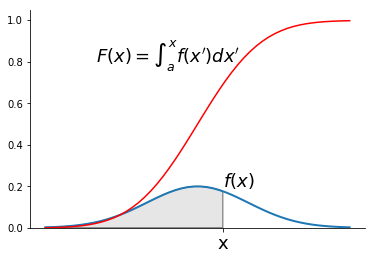

In [8]:
def gauss(x):
    '''
    Função gaussiana.
    '''
    x0 = 5
    sigma = 2
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-x0)/sigma)**2)

def int_x(x, f, n = 101):
    '''
    Essa função gera a função definida pela integral da função "f"
    começando em x_inf = x[0] e indo até o ponto.
    '''
    Y = np.zeros(len(x))
    L = (x[-1] - x[0]) # comprimento da região total de integração
    for ind_x in range(len(x)):
        porcent = (x[ind_x] - x[0])/L        # porcentagem do comprimento total
        ptos = int(np.floor(porcent * n)) # quantidade de ptos dependente do intervalo
        s = Simpson(x[0], x[ind_x], n)    # inicia o integrador 
        Y[ind_x] = s.integrate(f)            # integra e slava o resultado em 'Y'
    return Y
    

a, b, c = -1, 6, 11 # integral limits (a,b) plot limits (a,c)

x = np.linspace(a, c)
y = gauss(x)

F_x = int_x(x, gauss)


fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2)
ax.plot(x, F_x, color='red')
ax.set_ylim(bottom=0)
# ax.set_ylim(top=0.5)

ix = np.linspace(a,b)
iy = gauss(ix)
verts = [(a,0), *zip(ix,iy), (b,0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.4')
ax.add_patch(poly)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.text(0.1*(a+c),0.8,r"$F(x) = \int_a^x f(x^{\prime})dx^{\prime}$",
        fontsize=18)
ax.text(0.6*(a+c),0.2,r"$f(x)$",
        fontsize=18)

ax.set_xticks([b])
ax.set_xticklabels('x',fontsize=18)
plt.show()

**Pergunta:** Partindo de uma distribuição uniforme, no intervalo $[0,1]$ como gerar números com distribuição $f(x)$?

**Resposta:**
Seja *r* um número gerado com distribuição uniforme; tomamos

$$r = F(x)$$

e assim 

$$x = F^{-1}(r)$$

**Exemplo:**

Dipolo elétrico $\vec{\mu}$ em um fluído à temperatura $T$. Suponha que seja aplicado um campo eletrostático uniforme $\vec{E}$, a energia de interação do dipolo com o campo é

$$ V(\theta) = \mu |\vec{E}| \cos\theta $$

Para um sistema em equilíbrio:

$$f(\theta) = C e^{K \cos \theta} \sin \theta$$

com 
$$K = \frac{\mu |\vec{E}|}{k_B T}$$

$$C = \frac{K}{2 \sinh(K)}$$

...


De maneira que

$$F(\theta) = \int C \sin(\theta^{\prime}) \exp(K\cos\theta^{\prime}) d\theta^{\prime} = \frac{C}{K}(e^{K}-e^{K\cos\theta})$$


Concluindo em

$$ \theta = \arccos\left[\frac{1}{K} \log\left(e^{K}-\frac{Kr}{C}\right)\right]$$

**Exercício (4.5):**

Gerar N números aleatórios com a distribuição dada por $f(\theta)$ acima, produzir um histograma e comparar com o gráfico de $f(\theta)$.

$$f(\theta) = C e^{K \cos \theta} \sin \theta $$

$$\theta = \arccos\left[\frac{1}{K} \log\left(e^{K}-\frac{Kr}{C}\right)\right]$$


Valor da integral sob a curva = 1


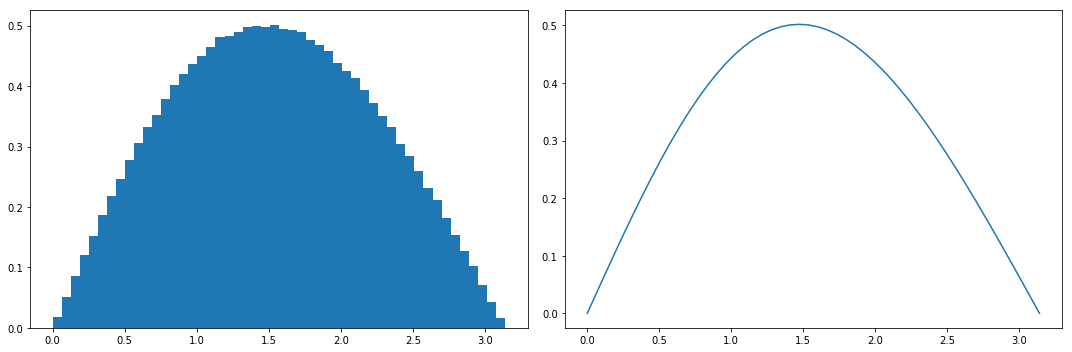

In [9]:

class F_theta:
    def __init__(self, T):
        self.T = T
        self.K = 1/T
        self.C = self.K/(2 * np.sinh(self.K))
    
    def theta_r(self,r):
        C, K = self.C, self.K
        return np.arccos(1/K * np.log(np.exp(K)-K*r/C))
        
    def __call__(self, theta):
        C, K = self.C, self.K
        return C * np.exp( K * np.cos(theta)) * np.sin(theta)
    



T = 10

simp = Simpson(0,np.pi,301)
f_dens = F_theta(T)

print("Valor da integral sob a curva = %1.2g" % simp.integrate(f_dens))

x_theta = np.linspace(0, np.pi)
y_theta = f_dens(x_theta)

N_points = 1000000 # A million of points
n_bins = 50 # number of bins

rand_unif = np.random.uniform(0, 1, N_points)
rand_theta = f_dens.theta_r(rand_unif) 

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(rand_theta,bins=n_bins,density=True)
ax2.plot(x_theta, y_theta)
plt.tight_layout()
# ax2.plot(x_theta, 1000000/sum(y_theta) * y_theta)
plt.show()

## E se não soubermos $F(x)$?

Consideremos uma distribuição conhecida (e complicada): a distribuição **lognormal**

$$f(x) =\frac{1}{x\sigma\sqrt{2\pi}} \exp\left[-\frac{(\ln x - \mu)^2}{2\sigma^2}\right]$$



In [10]:
class LogNormal:
    def __init__(self, sigma, x0):
        self.sigma = sigma
        self.x0 = x0
        self.mu = np.log(x0)
    
    def __call__(self, x):
        sigma, x0 = self.sigma, self.x0
        C_norm = 1/(sigma * np.sqrt(2*np.pi))
        Exp_x = np.exp(-(np.log(x/x0))**2/(2*sigma**2) )/x
        return C_norm * Exp_x 

# def func_log_normal(x, sigma=0.5, mu=1):
#     C = 1/(sigma * np.sqrt(2*np.pi))
#     E = np.exp(-(np.log(x) - mu)**2/(2*sigma**2) )/x
#     return C * E 
        

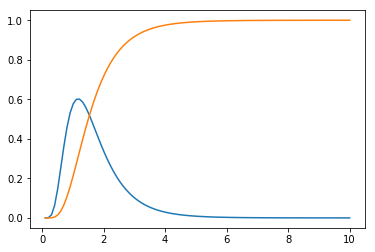

1.0


In [11]:
log_normal = LogNormal(0.5, 1.5)

x_log = np.linspace(0,10,100)[1:]
y_log_class = log_normal(x_log)

F_log = int_x(x_log, log_normal)
F_log /= F_log[-1]

plt.plot(x_log, y_log_class)
plt.plot(x_log, F_log)
# plt.plot(F_log, x_log)
plt.show()
print(F_log[-1])

**Procedimento:**
* Discretizamos o intervalo $[a,b]$ em n pontos, $[\tilde{x}_0,\tilde{x}_1,...,\tilde{x}_n]$;
* Calcula-se a integral numericamente: $F_j = F(\tilde{x}_j)$
* Sorteamos $r$ uniformemente distribuido entre $[0,1]$;
* Encontramos o menor *j* tal que $F_j > r$
* Interpolamos para achar o $x$ correspondente à $r$


$$ x = \tilde{x}_{j-1} + \frac{\Delta \tilde{x}}{F_j - F_{j-1}} (r - F_{j-1})$$

In [12]:
r_array = np.random.uniform(0,1,N_points)

def find_indx(r, F):
    # Encontra o menor índice 'j' tal que Fⱼ > r
    # Retorna: j, F[j], F[j-1] 
    for j in range(len(F)):
        if F[j] > r:
            if j == 0:
                return j, F[j], 0                
            return j, F[j], F[j-1]

def x_rand_log(r):
    ind, Fmaior, Fmenor = find_indx(r, F_log)
    Δ̃x = x_log[ind] - x_log[ind-1]
    ΔF = Fmaior - Fmenor
    x_r_log = x_log[ind-1] + (r-Fmenor) * Δ̃x/ΔF
    return x_r_log

x_r = np.zeros(len(r_array))

for r_ind in range(len(r_array)):
    x_r[r_ind] = x_rand_log(r_array[r_ind]) 



**Normalização:**

Queremos comparar o histograma dos $N$ pontos aleatórios com o gráfico da função densidade de probabilidade $f(x)$. Para isso precisamos fazer com que a área do Histograma e aquela abaixo da curva de $f(x)$ sejam aproximadamente iguais.

Sejam $n_{\text{b}}$ e $n$ os números de intervalos para o histograma (*bins*) e o números de pontos (igualmente espaçados) do domínio da $f(x)$ respectivamente, temos:

$$ A_{\text{his}} = \sum_{i=1}^{n_{\text{b}}} h_i \Delta x_{\text{h}} = \Delta x_{\text{h}} \sum_{i=1}^{n_{\text{b}}} h_i \\= N \Delta x_{\text{h}} $$

$$ A_{\text{gra}} = \sum_{i=1}^{n} f(x_i) \Delta x_{\text{g}} =  \Delta x_{\text{g}} \sum_{i=1}^{n} f(x_i) \\
= \text{sum}(y) \Delta x_{\text{g}}$$

Onde $h_i$ é a altura da i-ésima coluna do histograma e $\Delta x_{\text{h}}$ é o intervalo compreendido por cada um do $n_{\text{b}}$ bins. Enquanto que $\Delta x_{\text{g}}$ é o espaçamento de cada co-ordenada do gráfico. 

Assim, se *normalizarmos* $f(x)$ dividindo cada ponto $y_i = f(x_i)$ por $\text{sum}(y) \Delta x_{\text{g}}$ teremos uma área aproximadamente unitária. Se, depois disso, multiplicarmos tais valores normalizados por $N \Delta x_{\text{h}}$, teremos uma curva cuja área será aproximadamente a mesma do Histograma.

Para colocar no código:

$$ N \Delta x_{\text{h}} = N \frac{L}{n_{\text{b}}}$$

$$ \frac{N \Delta x_{\text{h}}}{\text{sum}(y)~ \Delta x_{\text{g}}} f(x) = 
   \frac{N ~L}{n_{\text{b}}~ \text{sum}(y)~ \Delta x_{\text{g}}} f(x) \\
   = \frac{n_{\text{g}}}{n_{\text{b}}}\frac{N}{\text{sum}(y)} f(x)= \frac{\text{len}(x_{\text{array}})}{n_{\text{b}}}\frac{N}{\text{sum}(y)} f(x)$$
   
Onde usamos $L/\Delta x_{\text{g}} = n_{\text{g}} = \text{len}(x_{\text{array}})$, em que $L$ é o comprimento do domínio da função definida no intervalo $[a,~b]$, ou seja, $L = b - a$.

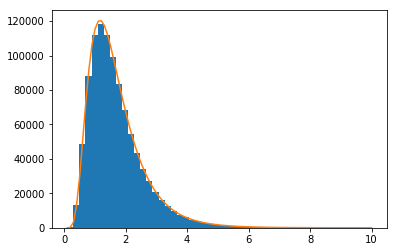

In [13]:
plt.hist(x_r, bins=n_bins)
plt.plot(x_log, (len(x_log)/n_bins) * N_points/sum(y_log_class) * y_log_class)
plt.show()

# Teorema do limite central

In [14]:

# def distr_media(N, ):
#     x_r = np.zeros(10)



# Método Monte Carlo

Ou método da Rejeição:
* Aplicabilidade muito geral
* Números aleatórios em $d$ dimensões: $\vec{x} = (x1,x2,\cdots,x_d)$

**Prodecimento:**

1. Seja $f(\vec{x})$ a densidade de probabilidade definida em uma região $R=\{(a_1,b_1),(a_2,b_2),\cdots,(a_d,b_d)\}$;
2. Normalizamos $f(\vec{x})$ de modo que `max(f(x_vec))=1`;
3. Geramos $d$ (dimensão) números aleátorios com distr. uniforme entre $a_j$ e $b_j$: `xj = aj + (bj - aj) * rj`;
4. Calculamos $f(\vec{x})$;
5. Geramos um número aleatório, uniforme $r$ entre 0 e 1;
6. Testamos o valor de $r$:
     + Se $r \leq f(\vec{x})$, aceitamos $\vec{x}$ como um ponto para nossa amostra;
     + Se $r > f(\vec{x})$, rejeitamos $\vec{x}$ e voltamos para o item 3. 

**Exemplo:**

Consideremos a distribuição de $x=(\theta, \phi)$ com $0\leq \theta \leq \pi$ e $0\leq \phi \leq 2\pi$ Distribuição de equilíbrio da orientação de um dipolo elétrico ou magnético, em presença de uma anisotropia uniaxial na direção $\mathbf{z}$ e um campo na direção $\mathbf{x}$, sendo $\theta$ e $\phi$ seus ângulos polares.

$$ f(\theta, \phi) = \sin(\theta) \exp[K \cos^2(\theta) - 1] + H[\sin(\theta)\cos(\phi) -1]$$




1.0


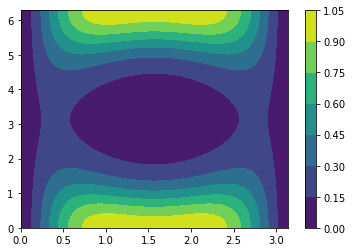

In [15]:
def f_theta_phi(θ, ϕ, K=1.5, H=1.5):
    return np.sin(θ) * np.exp(K * ((np.cos(θ))**2 - 1) 
                              + H * (np.sin(θ)*np.cos(ϕ) - 1))


theta = np.linspace(0, np.pi, 101)
phi = np.linspace(0, 2*np.pi, 201)

x, y = np.meshgrid(theta, phi)
z = f_theta_phi(x,y)
Max = np.max(z)
z /= Max 
print(np.max(z))

plt.contourf(x,y,z)
plt.colorbar()
plt.show()

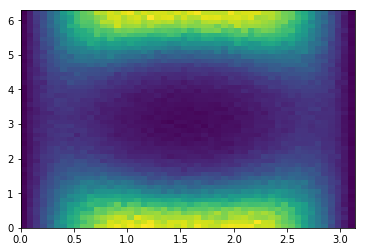

In [16]:
def sortea_theta_phi():
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2*np.pi)
    return theta, phi

def sortea_r_test(F):
    r_test = np.random.uniform(0,1)
    if r_test <= F: return True
    else: return False

def monte_carlo_2D(N, Maxf, func):
    x, y = np.zeros([2, N])
    count = 0
    
    while count != N-1:
        rx, ry  = sortea_theta_phi()
        F_rx_ry = func(rx, ry)/Maxf
        if sortea_r_test(F_rx_ry):
            x[count] = rx
            y[count] = ry
            count += 1
    return x, y
        

x_mont, y_mont = monte_carlo_2D(1000000, Max, f_theta_phi)

plt.hist2d(x_mont, y_mont, bins=50)
plt.show()
    
    

**Exercício (4.6):**

Gere $N$ números aleatórios com distribuição lognormal usando o método de Monte Carlo. Faça um histograma desses números e compare com a função lognormal.

